In [1]:
%reset -f
%matplotlib inline
%load_ext autoreload
%autoreload 2

# Generic imports
import matplotlib.pyplot as plt
import numpy as np
import glob, datetime, os

from astropy.wcs import WCS
from astropy.io import fits as fits

from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.time import Time

import astroscrappy

# Disable some annoying warnings from astropy
import warnings
from astropy.wcs import FITSFixedWarning
from astropy.io.fits.verify import VerifyWarning
warnings.simplefilter(action='ignore', category=FITSFixedWarning)
warnings.simplefilter(action='ignore', category=VerifyWarning)

# Our sub-modules
from stdpipe import astrometry, photometry, catalogs, cutouts, templates, subtraction, plots, pipeline, utils



# Simple transient detection pipeline

It shows how to use the higher-level functions from the package to construct simple pipeline
that detects transients.

It assumes that the image is already pre-processed (i.e. dark-subtracted and flat-fielded

## Load and prepare the image

Processing 2018cow_20180620_043017_Jun8keuq_kait_clear_c.fit: filter Clear, 500x500
Done masking cosmics


Text(0.5, 1.0, '2018cow_20180620_043017_Jun8keuq_kait_clear_c.fit')

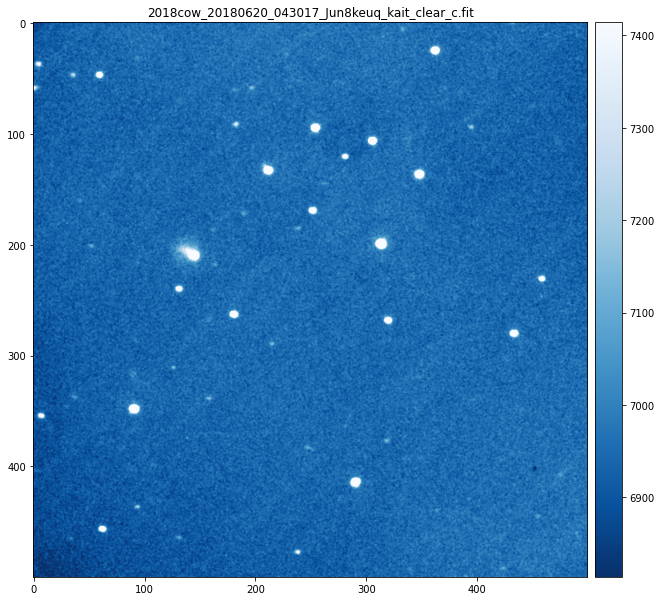

In [2]:
# FRAM pre-processed image containing GRB200306C, white light
# filename = '../tests/20200306225139-338-RA.fits'

# KAIT image of 2018cow
filename = '../tests/2018cow_20180620_043017_Jun8keuq_kait_clear_c.fit'

header = fits.getheader(filename)
image = fits.getdata(filename).astype(np.double)

fname = header.get('FILTER', 'Clear')
time = utils.get_obs_time(header, verbose=False)

print('Processing %s: filter %s, %dx%d' % (os.path.split(filename)[1], fname, image.shape[1], image.shape[0]))

# Create mask of bad pixels
mask = image > 50000 # Rough saturation level

# Cosmics
cmask, cimage = astroscrappy.detect_cosmics(image, mask, verbose=False)
mask |= cmask
print('Done masking cosmics')

plots.imshow(image, [0.5, 99.75], cmap='Blues_r')
plt.title(os.path.split(filename)[1])

## Object detection, astrometric refinement and photometric calibration

In [3]:
# Initial WCS
wcs = WCS(header)

# Extract objects
obj = photometry.get_objects_sextractor(image, mask=mask, r0=2, aper=5.0, wcs=wcs)
print(len(obj), 'objects found')

ra0,dec0,sr0 = astrometry.get_frame_center(wcs=wcs, width=image.shape[1], height=image.shape[0])
pixscale = astrometry.get_pixscale(wcs=wcs)

cat = catalogs.get_cat_vizier(ra0, dec0, sr0, 'ps1', filters={'rmag':'<19'})
print(len(cat), 'catalogue stars')

cat_col_mag = 'rmag'
cat_color_mag1 = 'gmag'
cat_color_mag2 = 'rmag'

# WCS refinement
wcs = pipeline.refine_astrometry(obj, cat, 5*pixscale, wcs=wcs, order=0, cat_col_mag=cat_col_mag, verbose=True)
if wcs is None or not wcs.is_celestial:
    print('WCS refinement failed')

# Update WCS info in the header
astrometry.clear_wcs(header, remove_comments=True, remove_underscored=True, remove_history=True)
header.update(wcs.to_header(relax=True))

# Photometric calibration
m = pipeline.calibrate_photometry(obj, cat, pixscale=pixscale, cat_col_mag=cat_col_mag, cat_col_mag1=cat_color_mag1, cat_col_mag2=cat_color_mag2, order=0, verbose=True)

33 objects found
51 catalogue stars
Astrometric refinement using 4.0 arcsec radius, photometric matching and astropy WCS fitting
Iteration 0: 16 matches, 0.2 arcsec rms
Iteration 1: 16 matches, 0.1 arcsec rms
Iteration 2: 16 matches, 0.1 arcsec rms
Performing photometric calibration of 33 objects vs 51 catalogue stars
Using 1.4 arcsec matching radius, rmag magnitude and spatial order 0
Using (gmag - rmag) color for color term
Photometric calibration finished successfully.
Color term is 0.20


<AxesSubplot:title={'center':'22 stars: mean displacement 0.2 arcsec, median 0.2 arcsec'}>

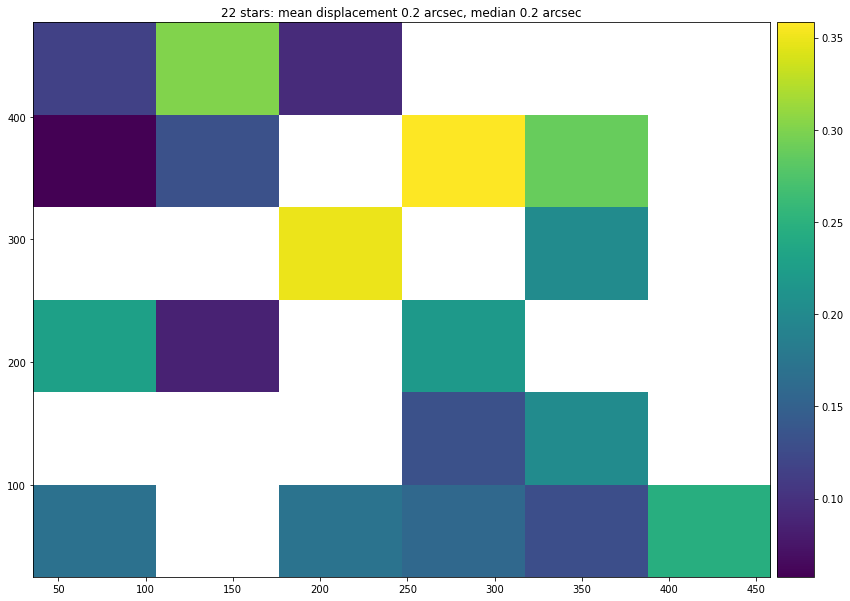

In [4]:
plots.plot_photometric_match(m, mode='dist', bins=6)

<AxesSubplot:title={'center':'color term = 0.20'}, xlabel='Catalogue color', ylabel='Model - Instrumental'>

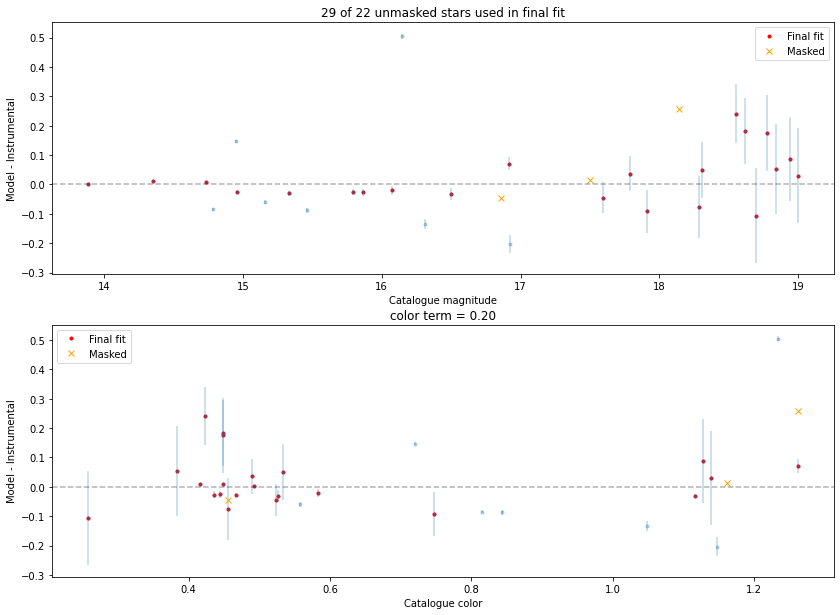

In [5]:
plt.subplot(211)
plots.plot_photometric_match(m)

plt.subplot(212)
plots.plot_photometric_match(m, mode='color')

## Catalogue based transient detection

Candidate filtering routine started with 33 initial candidates and 1.4 arcsec matching radius
30 of them are unflagged
1 of them are not matched with reference catalogue
1 remains after matching with PanSTARRS DR1
1 remains after matching with USNO-B1
1 remains after matching with GSC 2.2
1 remains after matching with SkyBot
1 candidates remaining after filtering
0 mag 14.182513012806563 at 244.00130076610833 22.26827935878991


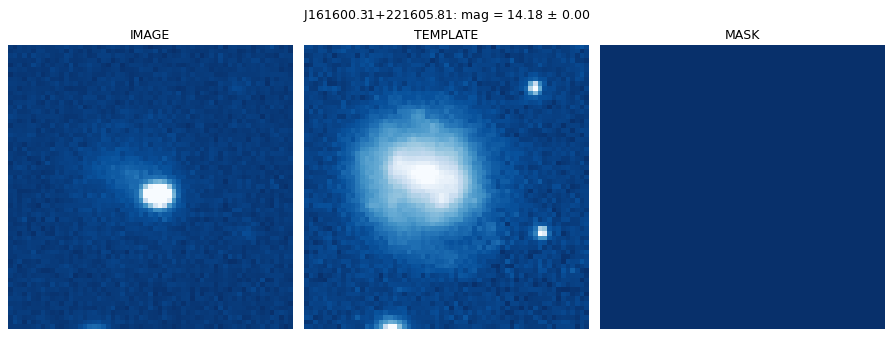

In [6]:
# Filter out catalogue objects
candidates = pipeline.filter_transient_candidates(obj, cat=cat, pixscale=pixscale, time=time, verbose=True)

# Display cutouts
for i,cand in enumerate(candidates):
    print(i, 'mag', cand['mag_calib'], 'at', cand['ra'], cand['dec'])
    cutout = cutouts.get_cutout(image, cand, 30, mask=mask, header=header, filename=filename)
    cutout['template'] = templates.get_hips_image('PanSTARRS/DR1/r', header=cutout['header'])[0]

    plots.plot_cutout(cutout, asinh=True)
    plt.show()

## Image template from PanSTARRS using HiPS service

Text(0.5, 1.0, 'Template image')

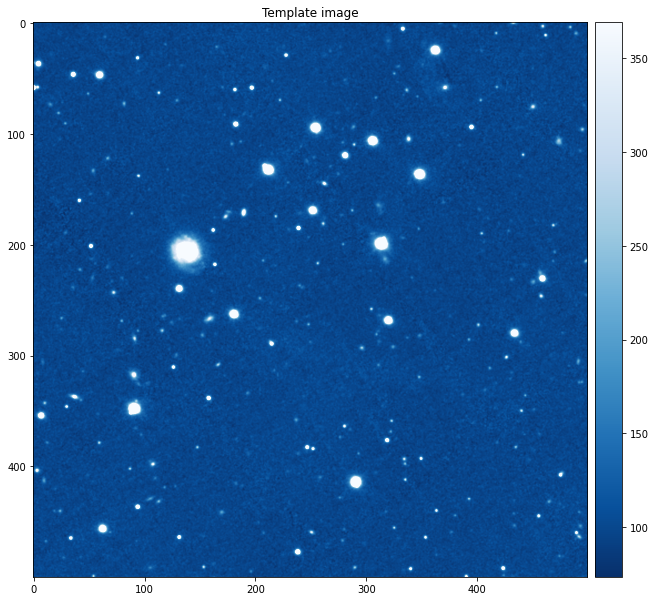

In [7]:
tmpl = templates.get_hips_image('PanSTARRS/DR1/r', header=header, get_header=False)

plots.imshow(tmpl, cmap='Blues_r')
plt.title('Template image')

## Mask for template image

Catalogue saturates at magnitude 15.1603


Text(0.5, 1.0, 'Final mask for the template')

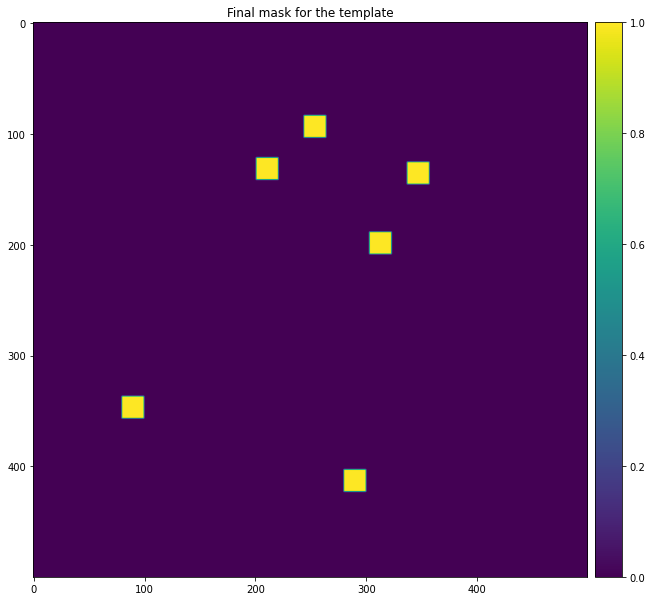

In [8]:
# TODO: should be wrapped into some higher-level routine

# Mask pixels returned as NaNs
tmask = ~np.isfinite(tmpl) 

tobj = photometry.get_objects_sextractor(tmpl, mask=tmask, sn=3, wcs=wcs, aper=3)

m_tmpl = photometry.match(tobj['ra'], tobj['dec'], tobj['mag'], tobj['magerr'], tobj['flags'], cat['RAJ2000'], cat['DEJ2000'], cat['rmag'], cat_magerr=cat['e_rmag'], cat_saturation=13, sr=1/3600)

tmpl_saturation = np.min(cat[m_tmpl['cidx']][m_tmpl['idx']]['rmag'])

print('Catalogue saturates at magnitude', tmpl_saturation)

# plt.subplot(211)
# plots.plot_photometric_match(m_tmpl)
# plt.show()

cx, cy = wcs.all_world2pix(cat['RAJ2000'], cat['DEJ2000'], 0)
tidx = cat['e_rmag'].mask
tidx |= cat['rmag'] < tmpl_saturation
tidx &= (cx > 1) & (cx < image.shape[1] - 2)
tidx &= (cy > 1) & (cy < image.shape[0] - 2)

# Mask also pixels in the centers of saturated stars
tmask[cy[tidx].astype(np.int), cx[tidx].astype(np.int)] = True 

# We may also dilate the mask a bit to better cover saturated regions
from scipy.ndimage import binary_dilation
kernel = np.ones([20, 20])
tmask = binary_dilation(tmask, kernel)

plots.imshow(tmask)
plt.title('Final mask for the template')

## Image subtraction using HOTPANTS

In [9]:
tobj = photometry.get_objects_sextractor(tmpl, mask=tmask, sn=10)
tobj = tobj[tobj['flags'] == 0]

t_fwhm = np.median(tobj['fwhm']) # [m_tmpl['oidx']][m_tmpl['idx']])
i_fwhm = np.median(obj['fwhm'][obj['flags'] == 0])

print(t_fwhm, i_fwhm)

diff,conv,sdiff,ediff = subtraction.run_hotpants(image, tmpl, mask=mask|tmask, template_mask=tmask, get_convolved=True, get_scaled=True, get_noise=True, verbose=True, image_fwhm=i_fwhm, template_fwhm=t_fwhm, extra={'c':'t', 'ko':0, 'bgo':0})

1.5186023 3.548871
Will run HOTPANTS like that:
hotpants -inim /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpants68cjlc5j/image.fits -tmplim /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpants68cjlc5j/template.fits -outim /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpants68cjlc5j/out.fits -imi /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpants68cjlc5j/imask.fits -tmi /var/folders/82/92l2np5529qbpckrl8ttlj200000gn/T/hotpants68cjlc5j/tmask.fits -il 6517.0 -iu 19430.0 -tl 26.53511 -tu 49293.12 -n i -allm -ng 3 6 0.6824559827974803 4 1.3649119655949606 2 2.7298239311899213 -r 18 -rss 43 -c t -ko 0 -bgo 0
HOTPANTS run succeeded


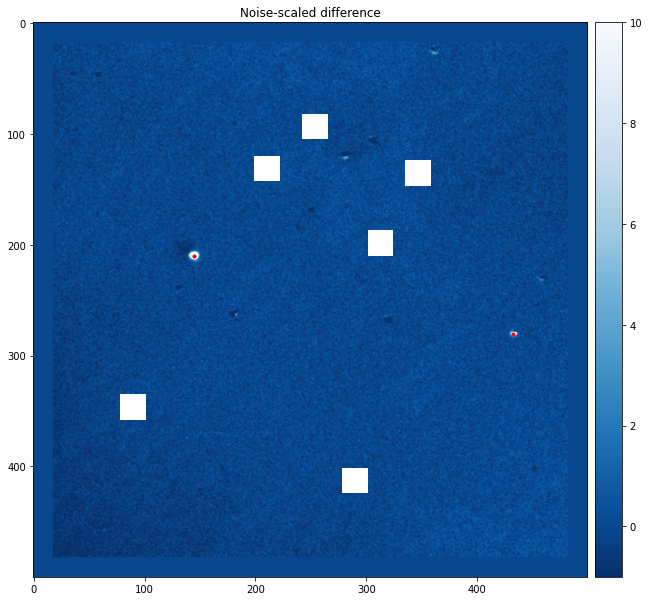

In [10]:
sdiff[mask|tmask] = np.nan
plots.imshow(sdiff, vmin=-1, vmax=10, cmap='Blues_r')
plt.title('Noise-scaled difference')

# We may now run object detection on difference image using noise model returned by HOTPANTS
sobj = photometry.get_objects_sextractor(diff, mask=mask|tmask, err=ediff, r0=np.median(obj['fwhm'])/2, sn=3, edge=50)
sobj = sobj[sobj['flags'] == 0]

plt.plot(sobj['x'], sobj['y'], 'r.')

0 mag 14.49529243938127 at 144.74852 209.8118 - 244.00091248263442 22.26806597987406


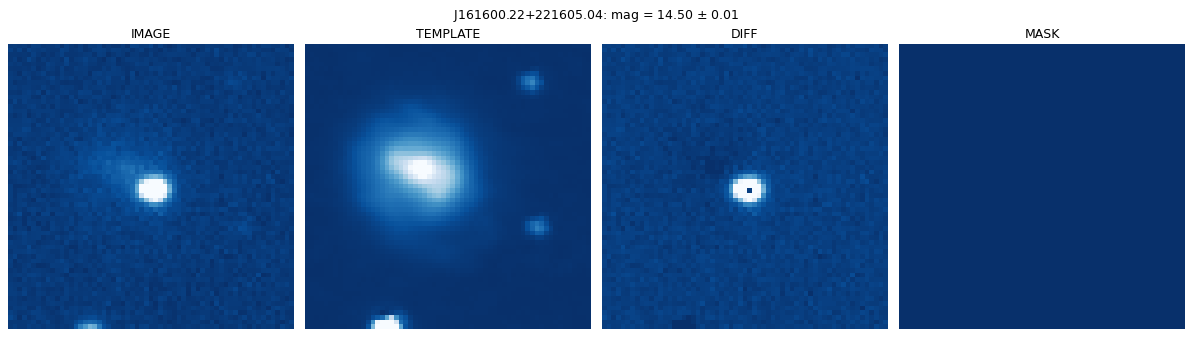

1 mag 16.63549305431047 at 432.7009 280.3112 - 243.93207301332325 22.252884013046717


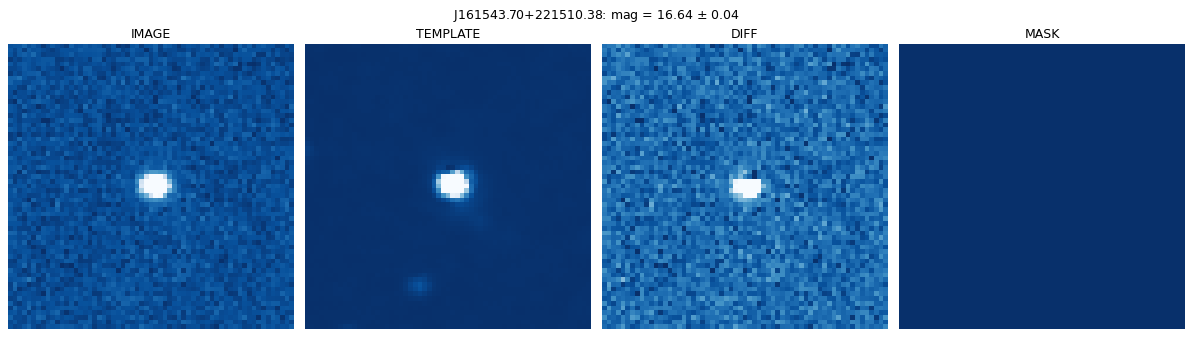

In [11]:
# And now we may check the cutouts around the transients detected by image subtraction

sobj['id'] = np.arange(len(sobj))
sobj['mag_calib'] = sobj['mag'] + m['zero_fn'](sobj['x'], sobj['y'])
sobj['ra'],sobj['dec'] = wcs.all_pix2world(sobj['x'], sobj['y'], 0)

for cand in sobj:
    print(cand['id'], 'mag', cand['mag_calib'], 'at', cand['x'], cand['y'], '-', cand['ra'], cand['dec'])
    cutout = cutouts.get_cutout(image, cand, 30, mask=mask|tmask, diff=diff, template=conv, err=ediff, header=header, filename=filename)

    plots.plot_cutout(cutout, nplots=4)
    plt.show()



## We may even try to play with sub-pixel alignment to get better subtraction

In [12]:
from scipy.optimize import minimize
from scipy.ndimage.interpolation import shift

def fn(dx, cutout=None):
    return np.std((cutout['image']-shift(cutout['template'], dx, mode='reflect'))/cutout['err'])

res = minimize(fn, (0, 0), args=(cutout,), bounds=((-2,2),(-2,2)), method='Powell', options={'disp':True})
res

Optimization terminated successfully.
         Current function value: 0.887200
         Iterations: 2
         Function evaluations: 41


   direc: array([[1., 0.],
       [0., 1.]])
     fun: 0.8871995957762483
 message: 'Optimization terminated successfully.'
    nfev: 41
     nit: 2
  status: 0
 success: True
       x: array([ 0.28743076, -0.09014882])

Text(0.5, 1.0, 'Adjusted position')

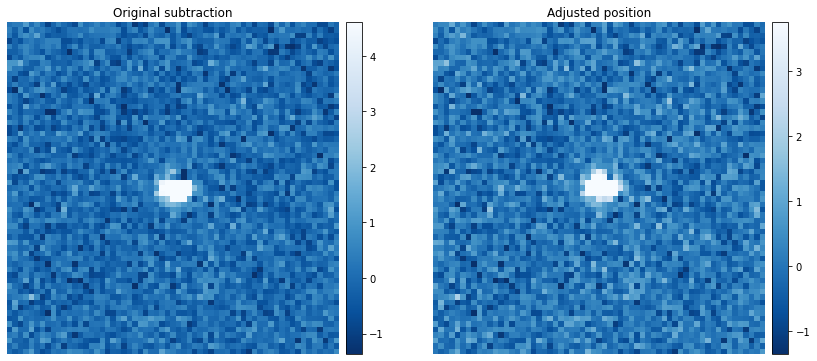

In [13]:
plt.subplot(121)
plots.imshow((cutout['image']-shift(cutout['template'], [0,0], mode='reflect'))/cutout['err'], show_axis=False, cmap='Blues_r')
plt.title('Original subtraction')

plt.subplot(122)
plots.imshow((cutout['image']-shift(cutout['template'], res.x, mode='reflect'))/cutout['err'], show_axis=False, cmap='Blues_r')
plt.title('Adjusted position')

